In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd
import matplotlib.image as img
import gc
from sklearn.metrics import classification_report
import cv2
from tensorflow import keras
from tensorflow.keras.layers import *
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split as tts
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
label = []
file_path = []
training_path = "archive/AugmentedAlzheimerDataset"
categories = os.listdir(training_path)
for category in categories:
    for file in os.listdir(os.path.join(training_path, category)):
        file_path.append(os.path.join(training_path, category, file))
        label.append(category)
final_data = pd.DataFrame(list(zip(file_path, label)), columns = ["file_path", "label"])
le = preprocessing.LabelEncoder()
le.fit(final_data["label"])

LabelEncoder()

In [3]:
images = []
for i in final_data.iterrows():
    image = cv2.imread(i[1]["file_path"])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (150,150))
    image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    images.append(image)
images = np.array(images, dtype = "float32")

<AxesSubplot:ylabel='label'>

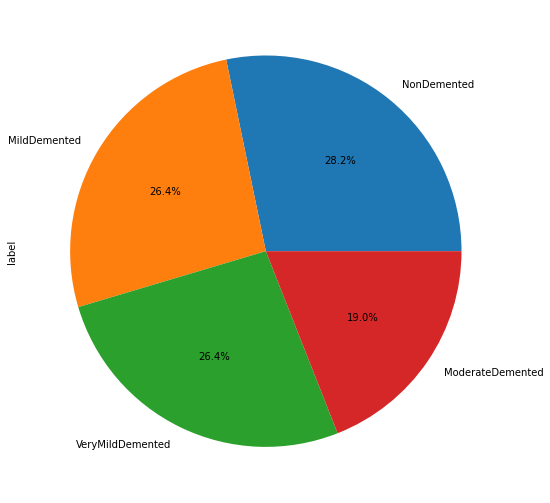

In [4]:
pie, ax = plt.subplots(figsize=[15,9])
(final_data["label"].value_counts()).plot.pie(autopct = "%.1f%%")

In [5]:
final_data["label"] = le.transform(final_data["label"])

In [5]:
x_train, x_test, y_train, y_test = tts(images, label, test_size = 0.3) #Train test split
x_train, x_val, y_train, y_val = tts(x_train, y_train, test_size = 0.15) #Train validation Split

In [6]:
x_train = np.array(x_train).astype('float32')
x_test = np.array(x_test).astype('float32')
y_train = np.array(y_train)
y_test = np.array(y_test)
x_val = np.array(x_val).astype('float32')
y_val = np.array(y_val)

y_train = le.transform(y_train).astype('float32')
y_test = le.transform(y_test).astype('float32')
y_val = le.transform(y_val).astype('float32')

In [7]:
print("Training Data Shape is: ", str(x_train.shape), str(y_train.shape))
print("Validation Data Shape is: ", str(x_val.shape), str(y_val.shape))
print("Testing Data Shape is: ", str(x_test.shape), str(y_test.shape))

Training Data Shape is:  (20219, 150, 150, 3) (20219,)
Validation Data Shape is:  (3569, 150, 150, 3) (3569,)
Testing Data Shape is:  (10196, 150, 150, 3) (10196,)


In [10]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(150,150,3))
base_model.trainable = False
# Define the model architecture
model = Sequential([
    base_model,
    Flatten(),
    Dense(4096, activation = "relu"),
    Dropout(0.5),
    Dense(2048, activation = "relu"),
    Dropout(0.5),
    Dense(4, activation = "softmax")
    ])
print(model.summary())

# Compile the model
model.compile(loss = "SparseCategoricalCrossentropy", 
          optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5), 
          metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 4096)              33558528  
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 2048)              8390656   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 4)                 8

In [11]:
acc_per_fold = []
loss_per_fold = []
histories = []
kfold = KFold(n_splits=10, shuffle=True)
fold_no = 1
for train, test in kfold.split(x_train, y_train):
    gc.collect()
    gc.collect()
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    # Fit data to model
    history = model.fit(x_train[train], y_train[train],
                        validation_data= [x_val, y_val],
                          batch_size=2,
                          epochs=5,
                          verbose=1)
    histories.append(history)
    # Generate generalization metrics
    scores = model.evaluate((x_train)[test], (y_train)[test], verbose=0)
    print(f"Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%")
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no += 1
    gc.collect()
    gc.collect()

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/5
9099/9099 [==============================] - 145s 15ms/step - loss: 1.0378 - accuracy: 0.5346 - val_loss: 0.7369 - val_accuracy: 0.6669
Epoch 2/5
9099/9099 [==============================] - 138s 15ms/step - loss: 0.7354 - accuracy: 0.6734 - val_loss: 0.6148 - val_accuracy: 0.7243
Epoch 3/5
9099/9099 [==============================] - 140s 15ms/step - loss: 0.6292 - accuracy: 0.7244 - val_loss: 0.6474 - val_accuracy: 0.7030
Epoch 4/5
9099/9099 [==============================] - 141s 15ms/step - loss: 0.5498 - accuracy: 0.7620 - val_loss: 0.4869 - val_accuracy: 0.7876
Epoch 5/5
9099/9099 [==============================] - 140s 15ms/step - loss: 0.4940 - accuracy: 0.7877 - val_loss: 0.4773 - val_accuracy: 0.8027
Score for fold 1: loss of 0.45494216680526733; accuracy of 82.09693431854248%
------------------------------------------------------------------------
Training for fold 2 ..

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
predictions = model.evaluate(x_test, y_test)

In [12]:
predictions = model.predict(x_test)
print(classification_report(y_test, np.argmax(predictions, axis = 1)))

319/319 [==============================] - 16s 48ms/step
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      2761
         1.0       1.00      1.00      1.00      1976
         2.0       0.95      0.96      0.96      2830
         3.0       0.96      0.93      0.95      2629

    accuracy                           0.97     10196
   macro avg       0.97      0.97      0.97     10196
weighted avg       0.97      0.97      0.97     10196



In [14]:
histories[0]

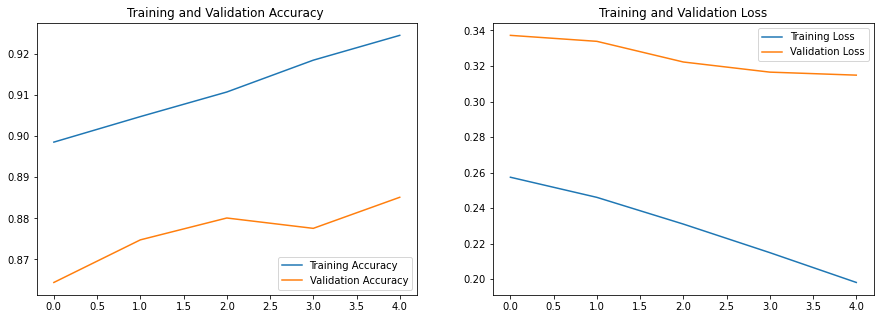

In [22]:
history = histories[5]
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(5)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy ')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()